# ***MNIST Example***

In [1]:
# please make sure that you have the following libraries, otherwise you shall install them.
# just uncomment the pip command down below and run this cell
# %pip install numpy matplotlib idx2numpy os plotly
# pip install -U kaleido   # in cmd

In [2]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
from os import listdir, mkdir
from os.path import isfile, join, isdir
import plotly.graph_objects as go
from time import time

In [3]:
X_train = idx2numpy.convert_from_file(
    './dataset/train-images-idx3-ubyte').reshape(60000, 784)
X_cv, X_train = X_train[0 : 10000, :], X_train[10000 ::, :]
X_test = idx2numpy.convert_from_file(
    './dataset/t10k-images-idx3-ubyte').reshape(10000, 784)
y_train = idx2numpy.convert_from_file('./dataset/train-labels-idx1-ubyte')
y_cv, y_train = y_train[0 : 10000], y_train[10000 ::]
y_test = idx2numpy.convert_from_file('./dataset/t10k-labels-idx1-ubyte')

In [4]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)
print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)

(50000, 784)
(10000, 784)
(10000, 784)
(50000,)
(10000,)
(10000,)


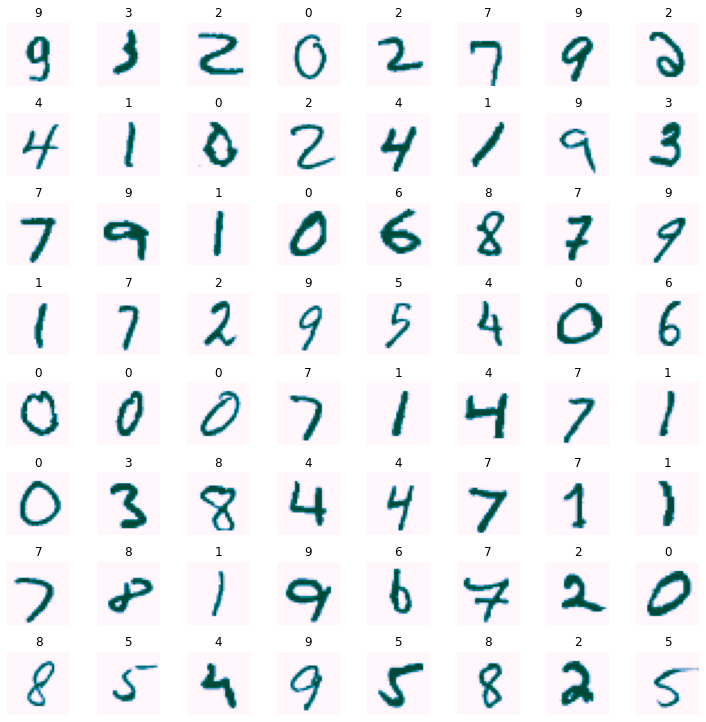

In [5]:
m, n = X_train.shape

fig, axes = plt.subplots(8, 8, figsize=(10, 10))
fig.tight_layout(pad=0.1)

for i, ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)

    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X_train[random_index].reshape((28, 28))

    # Display the image
    ax.imshow(X_random_reshaped, cmap='PuBuGn')

    # Display the label above the image
    ax.set_title(y_train[random_index])
    ax.set_axis_off()

In [6]:
def relu(Z): return np.maximum(0, Z)

def sigmoid(Z): return 1.0 / (1.0 + np.exp(-Z))

def softmax(Z):
    exponentias = np.exp(Z - np.max(Z, axis=1).reshape(-1, 1))
    return exponentias / np.sum(exponentias, axis=1).reshape(-1, 1)

def relu_derevative(Z): return Z > 0

def sigmoid_derevative(sig): return sig * (1.0 - sig)

def softmax_grad(soft):
    s = soft.reshape(-1, 1)
    return np.diagflat(s) - np.dot(s, s.T)


In [7]:
class Layer:
    def __init__(self, neurons, activation, activation_drev):
        self.neurons = neurons
        self.activation = activation
        self.activation_drev = activation_drev

In [8]:
class NeuralNetwork:
    def __init__(self, X_train, X_cv, X_test, y_train, y_cv, y_test, **layers):
        self.m = X_train.shape[0]
        self.epsilon = 1e-8
        
        self.X_train_norm = X_train / 255
        self.X_test_norm = X_test / 255
        self.X_cv_norm = X_cv / 255

        self.y_train = np.array([self.convert2_OneHotEncodeing(y) for y in y_train])
        self.y_cv = np.array([self.convert2_OneHotEncodeing(y) for y in y_cv])
        self.y_test = np.array([self.convert2_OneHotEncodeing(y) for y in y_test])

        self.layers = list(layers.items())
        self.Weights = []
        self.Biases = []
        self.V_dw = []
        self.V_db = []
        self.S_dw = []
        self.S_db = []

        self.j_train = np.array([])
        self.accuracy = np.array([])
        
        for index, layer in enumerate(self.layers):
            if index == 0:
                self.Weights.append(np.random.rand(
                    self.X_train_norm.shape[1], layer[1].neurons) * 0.1 - 0.05)
            else:
                self.Weights.append(np.random.rand(
                    self.layers[index - 1][1].neurons, layer[1].neurons) * 0.1 - 0.05)
            self.Biases.append(np.zeros(shape=(1, layer[1].neurons)))

            self.V_dw.append(np.zeros_like(self.Weights[index]))
            self.V_db.append(np.zeros_like(self.Biases[index]))
            self.S_dw.append(np.zeros_like(self.Weights[index]))
            self.S_db.append(np.zeros_like(self.Biases[index]))

    def convert2_OneHotEncodeing(self, index):
        e = np.zeros((10))
        e[index] = 1.0
        return e

    def data_normalize(self, X):
        X_norm = [0 for i in range(X.shape[1])]
        for index in range(X.shape[1]):
            avg = np.average(X[:, index])
            std = np.std(X[:, index])
            if std != 0:
                X_norm[index] = (X[:, index] - avg) / std
            else:
                X_norm[index] = X[:, index]
        return np.array(X_norm).T

    def parameters(self):
        n_weights = 0
        for W, B in zip(self.Weights, self.Biases):
            n_weights += np.size(W) + np.size(B)
        return n_weights

    def dense(self, A_in, W, B, activation):
        Z = np.matmul(A_in, W) + B
        self.Z.append(Z)
        A_out = activation(Z)
        return A_out

    def forwardPropagation(self, X):
        self.A = [X]
        self.Z = []
        for index, layer in enumerate(self.layers):
            self.A.append(self.dense(
                self.A[index], self.Weights[index], self.Biases[index], layer[1].activation))
        self.y_predict = self.A[-1]

    def backwardPropagation(self, y_batch, learning_rate, lambda_, beta1, beta2, t):
        delta = self.cross_entropy_grad(y_batch) / self.m
        dw = np.matmul(self.A[-2].T, delta)
        db = np.sum(delta, axis=0).reshape(1, -1)
        for index in reversed(np.arange(len(self.layers))):
            self.V_dw[index], self.V_db[index] = beta1 * self.V_dw[index] + (1.0 - beta1) * dw, beta1 * self.V_db[index] + (1.0 - beta1) * db
            self.S_dw[index], self.S_db[index] = beta2 * self.S_dw[index] + (1.0 - beta2) * (dw ** 2), beta2 * self.S_db[index] + (1.0 - beta2) * (db ** 2)
            
            V_dw_correct, V_db_correct = self.V_dw[index] / (1.0 - beta1 ** (t + 1)), self.V_db[index] / (1.0 - beta1 ** (t + 1))
            S_dw_correct, S_db_correct = self.S_dw[index] / (1.0 - beta2 ** (t + 1)), self.S_db[index] / (1.0 - beta2 ** (t + 1))
            
            adam_dw = learning_rate * V_dw_correct / (np.sqrt(S_dw_correct) + self.epsilon)
            adam_db = learning_rate * V_db_correct / (np.sqrt(S_db_correct) + self.epsilon)
            
            self.Weights[index] = self.Weights[index] * (1 - learning_rate * lambda_ / self.m) - adam_dw
            self.Biases[index] -= adam_db

            if index == 0: break
            delta = np.matmul(
                delta, self.Weights[index].T) * self.layers[index - 1][1].activation_drev(self.Z[index - 1])
            dw = np.matmul(self.A[index - 1].T, delta)
            db = np.sum(delta, axis=0).reshape(1, -1)

    def fit(self, epochs=100, learning_rate=0.02, beta1=0.9, beta2=0.999, lambda_=0.0, mini_batch=128, learning_rate_decay=0.1):
        num_batches = int(self.m / mini_batch)
        tic = time()
        
        self.forwardPropagation(X=self.X_train_norm)
        self.j_train = np.append(self.j_train, self.cross_entropy(self.y_train, lambda_))
        acc = 100.0 * self.getAccuracy(y=self.y_train)
        self.accuracy = np.append(self.accuracy, acc)
        
        print(f'epoch: {0}')
        print(f'training set prediction accuracy {acc}')

        for epoch in np.arange(1, epochs + 1):
            start, end = 0, 0
            
            for batch in np.arange(num_batches):
                end = (batch + 1) * mini_batch
                X_batch, y_batch = self.X_train_norm[start:end, :], self.y_train[start:end, :]
                start = end
                self.forwardPropagation(X_batch)
                self.backwardPropagation(y_batch, learning_rate, lambda_, beta1, beta2, batch)

            X_batch, y_batch = self.X_train_norm[end::, :], self.y_train[end::, :]
            self.forwardPropagation(X_batch)
            self.backwardPropagation(y_batch, learning_rate, lambda_, beta1, beta2, batch)

            self.forwardPropagation(X=self.X_train_norm)
            self.j_train = np.append(self.j_train, self.cross_entropy(self.y_train, lambda_))
            acc = 100.0 * self.getAccuracy(y=self.y_train)
            self.accuracy = np.append(self.accuracy, acc)
            
            learning_rate /= (1.0 + learning_rate_decay * (epoch - 1))
            
            if epoch % 10 == 0:
                print(f'epoch: {epoch}')
                print(f'training set prediction accuracy {acc}')
                if np.abs(self.j_train[epoch] - self.j_train[epoch - 1]) <= self.epsilon:
                    break
        
        toc = time()
        self.executed_time = toc - tic
        self.testModel()

    def getAccuracy(self, y):
        return np.sum(
            np.argmax(self.y_predict, axis=1) == np.argmax(y, axis=1)
            ) / self.y_predict.shape[0]

    def testModel(self):
        x = np.arange(len(self.j_train))
        self.j_train_fig = go.Figure(go.Scatter(x=x, y=self.j_train)).update_layout( 
            title='Cost function of training examples', 
            xaxis_title='epochs', 
            yaxis_title='J_train', 
            template='plotly_dark')

        self.j_train_fig.show()
        self.accuracy_fig = go.Figure(go.Scatter(x=x, y=self.accuracy)).update_layout( 
            title='Accuracy of training examples', 
            xaxis_title='epochs', 
            yaxis_title='accuracy', 
            template='plotly_dark')

        self.accuracy_fig.show()

    def saveModel(self, index, learning_rate=0.02, beta1=0.9, beta2=0.999, lambda_=0.0, mini_batch=128, learning_rate_decay=0.1):
        if not isdir(f'./models/model_{index}/'):
            mkdir(f'./models/model_{index}/')

        # saving the plots we have done through the cost functions plots
        self.j_train_fig.write_image(f'./models/model_{index}/j_train_graph.png')
        self.accuracy_fig.write_image(f'./models/model_{index}/accuracy_graph.png')

        # saving parameters
        for i, (w, b) in enumerate(zip(self.Weights, self.Biases)):
            np.savetxt(f'./models/model_{index}/W_{i}.txt', w, fmt='%1.9f')
            np.savetxt(f'./models/model_{index}/B_{i}.txt', b, fmt='%1.9f')
        
        # saving the cost functions arrays
        np.savetxt(f'./models/model_{index}/J-train.txt', self.j_train, fmt='%1.9f')
        np.savetxt(f'./models/model_{index}/accuracy.txt', self.accuracy, fmt='%1.9f')
        
        # add model's summary 
        with open(f'./models/model_{index}/model_summary.md', "w") as f:
            f.write(f'# ***Model {index}***\n\n')
            f.write(f'Here is the summary of a trained model for the MNIST dataset.\n\n')
            f.write(f'## **1. Model Design**\n')
            f.write(f'## This model is consisted of *{len(self.layers)}* layers\n\n')

            for i in np.arange(len(self.layers)):
                f.write(f'Layer {i + 1}:\n')
                f.write(f'Layer {i + 1} is consisted of *{self.Weights[i].shape[1]}* neurons.\n\n')
                f.write(f'so the shape of its *Weights and Biases* are:\n\n')
                f.write(f'- Weights = {self.Weights[i].shape}\n\n')
                f.write(f'- Biases = {self.Biases[i].shape}\n\n')

            f.write(f'The total parameters of this model = {self.parameters()}\n')

            f.write(f'## **3. Model\'s Hyperparametes**\n')

            f.write(
                f'''- ### Model\'s hyperparameters are:\n
                Batch size (mini batch): {mini_batch} training examples\n
                Learning rate (alpha): {learning_rate}\n
                Learning rate decay: {learning_rate_decay}\n
                Regularization term -L2 regularization- (lambda): {lambda_}\n
                Gradient descent with momentum hyperparameter (beta 1): {beta1}\n
                RMSprop hyperparameter (beta 2): {beta2}\n\n'''
            )
            f.write(f'## **3. Model\'s Accuracy**\n')

            self.forwardPropagation(self.X_train_norm)
            train_loss = self.cross_entropy(self.y_train, lambda_)
            f.write(f'- ### Model\'s accuracy of the training examples:\
                {self.getAccuracy(self.y_train) * 100}\n\n')
            
            f.write(f'![Accuracy of training examples](./accuracy_graph.png)\n\n')

            self.forwardPropagation(self.X_cv_norm)
            cv_loss = self.cross_entropy(self.y_cv, lambda_)
            f.write(f'- ### Model\'s accuracy of the cross validating examples:\
                {self.getAccuracy(self.y_cv) * 100}\n\n')
            
            self.forwardPropagation(self.X_test_norm)
            test_loss = self.cross_entropy(self.y_test, lambda_)
            f.write(f'- ### Model\'s accuracy of the testing examples:\
                {self.getAccuracy(self.y_test) * 100}\n\n')

            f.write(f'## **4. Model\'s Losses**\n')

            f.write(f'- ### Model\'s losses of the training examples: {train_loss}\n\n')

            f.write(f'![Cost function of training examples](./j_train_graph.png)\n\n')

            f.write(f'- ### Model\'s losses of the cross validating examples: {cv_loss}\n\n')

            f.write(f'- ### Model\'s losses of the testing examples: {test_loss}\n\n')

            f.write(f'## **5. Model\'s Executed time**\n')

            f.write(f'- ### The executed time: {int(self.executed_time / 60)} minutes,, \
            {int(self.executed_time % 60)} seconds ,, \
                {((self.executed_time - int(self.executed_time)) * 1000):.2f} milli seconds, along {len(self.accuracy) - 1} epochs\n\n')

    def loadModel(self, index):
        path = f'./models/model_{index}/'
        files = [f for f in listdir(path) if isfile(join(path, f))]
        self.Biases, self.Weights = [], []

        for file in files:
            for i in np.arange(len(files)):
                if file == f'B_{i}.txt':
                    self.Biases.append(np.loadtxt(join(path, f'B_{i}.txt')).reshape(1, -1))
                    break
                elif file == f'W_{i}.txt':
                    self.Weights.append(np.loadtxt(join(path, f'W_{i}.txt')))
                    break

        if len(self.Biases) != len(self.Weights) != len(self.layers):
            print('failed to load the model due to an error:')
            print('len(self.Biases) not equal len(self.Weights)')
            print('please make sure you are loading the right model')
            self.Biases, self.Weights = [], []
            return

        if isfile(join(path, 'J-train.txt')): 
            self.j_train = np.loadtxt(join(path, 'J-train.txt'))
        else : print('failed to load J-train file')

        if isfile(join(path, 'accuracy.txt')): 
            self.j_train = np.loadtxt(join(path, 'accuracy.txt'))
        else : print('failed to load accuracy file')

        for w, b in zip(self.Weights, self.Biases):
            print(f'Weights: {w.shape}')
            print(f'Biases: {b.shape}')

    def cross_entropy(self, y, lambda_):
        regularization_term = 0
        
        for w in self.Weights:
            regularization_term += lambda_ / 2 * np.mean(w ** 2)

        y_pred_clipped = np.clip(self.y_predict, self.epsilon, 1 - self.epsilon)
        return np.mean(-y * np.log(y_pred_clipped)) + regularization_term

    def cross_entropy_grad(self, y): return self.y_predict - y

In [9]:
model = NeuralNetwork(
    X_train=X_train,
    X_cv=X_cv,
    X_test=X_test,
    y_train=y_train,
    y_cv=y_cv,
    y_test=y_test,
    layer1=Layer(neurons=25, activation=relu, activation_drev=relu_derevative),
    layer2=Layer(neurons=15, activation=relu, activation_drev=relu_derevative),
    layer3=Layer(neurons=10, activation=softmax, activation_drev=softmax_grad)
)

In [10]:
# Hyperparameters

ALPHA = 0.03
BETA_1 = 0.9
BETA_2 = 0.999
LAMBDA = 15.0
LEARNING_RATE_DECAY = 0.0005
NUM_EPOCHS = 200
MINI_BATCH = 256

In [11]:
model.fit(NUM_EPOCHS, ALPHA, BETA_1, BETA_2, LAMBDA, MINI_BATCH, LEARNING_RATE_DECAY)

epoch: 0
training set prediction accuracy 9.772
epoch: 10
training set prediction accuracy 97.092
epoch: 20
training set prediction accuracy 97.096
epoch: 30
training set prediction accuracy 97.274
epoch: 40
training set prediction accuracy 98.116
epoch: 50
training set prediction accuracy 98.32
epoch: 60
training set prediction accuracy 97.75
epoch: 70
training set prediction accuracy 99.25
epoch: 80
training set prediction accuracy 99.45
epoch: 90
training set prediction accuracy 99.846
epoch: 100
training set prediction accuracy 99.908
epoch: 110
training set prediction accuracy 99.966
epoch: 120
training set prediction accuracy 99.984
epoch: 130
training set prediction accuracy 99.992
epoch: 140
training set prediction accuracy 99.992
epoch: 150
training set prediction accuracy 99.992
epoch: 160
training set prediction accuracy 99.992
epoch: 170
training set prediction accuracy 99.992
epoch: 180
training set prediction accuracy 99.992
epoch: 190
training set prediction accuracy 99.

In [12]:
model.forwardPropagation(model.X_train_norm)
print(f'training set prediction accuracy {100 * model.getAccuracy(y=model.y_train)}')

model.forwardPropagation(model.X_cv_norm)
print(f'testing set prediction accuracy {100 * model.getAccuracy(y=model.y_cv)}')

model.forwardPropagation(model.X_test_norm)
print(f'testing set prediction accuracy {100 * model.getAccuracy(y=model.y_test)}')

training set prediction accuracy 99.992
testing set prediction accuracy 95.69
testing set prediction accuracy 95.89


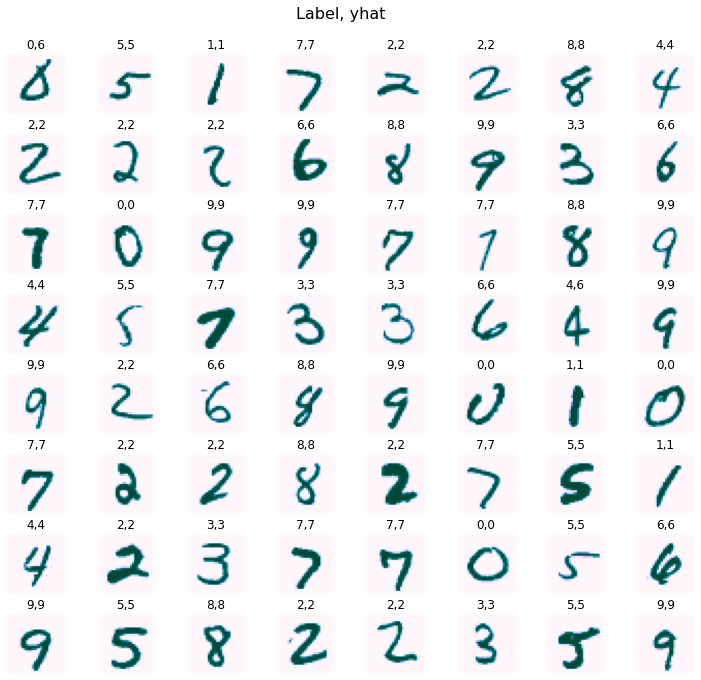

In [13]:
model.forwardPropagation(model.X_test_norm)

m, n = X_test.shape

fig, axes = plt.subplots(8, 8, figsize=(10, 10))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i, ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X_test[random_index].reshape((28,28))
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='PuBuGn')
    
    # Predict using the Neural Network
    yhat = np.argmax(model.y_predict[random_index])

    # Display the label above the image
    ax.set_title(f"{y_test[random_index]},{yhat}")
    ax.set_axis_off()

fig.suptitle("Label, yhat", fontsize=16)
plt.show()

In [14]:
model.saveModel(index=1, learning_rate=ALPHA, beta1=BETA_1, beta2=BETA_2, lambda_=LAMBDA, mini_batch=MINI_BATCH, learning_rate_decay=LEARNING_RATE_DECAY)